In [22]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder 


rc = {
    "axes.facecolor": "#FFFFFF",       
    "figure.facecolor": "#FFFFFF",
    "axes.edgecolor": "#000000",
    "grid.color": "#CCCCCC",
    "font.family": "malgun gothic",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4,
}

sns.set(rc = rc)
plt.rc('axes', unicode_minus = False)

# **차원 축소의 필요성**

이 전 단계에서 실루엣 계수에서 생겼던 문제점이 두 가지 있었다.


### **1. 불필요한 변수가 많이 들어가 실루엣 계수가 매우 낮았던 점** 
### **2. 가중치를 줘서 군집화를 하려던 시도가 실패했던 점** 

1번 문제를 해결하기 위해 무대의 좌표와 관련된 정보가 과연 독립적인가라는 의문이 들어 차원 축소를 시행해보았다. 

In [23]:
seat_table = pd.read_parquet("C:/Users/whileduck/Desktop/Github/Concert-Hall-Price-Model/data/seat_table.parquet")
reservation_table = pd.read_parquet("C:/Users/whileduck/Desktop/Github/Concert-Hall-Price-Model/data/reservation_table.parquet")
seat_information = pd.read_csv("C:/Users/whileduck/Desktop/Github/Concert-Hall-Price-Model/data/seat_information_angle_ver3.csv")

df = pd.read_parquet("C:/Users/whileduck/Desktop/Github/Concert-Hall-Price-Model/data/거래까지걸린시간_추가_클래식_데이터.parquet")

In [24]:
seat_table.columns

Index(['seat', '예매여부 sum', '좌석 오픈 여부 sum', '원가격추정 mean', '거래까지걸린시간_시간 mean',
       '거래까지걸린시간_등수 amax', '거래까지걸린시간_등수 amin', '표준화 등수 점수 mean', '좌석 예매율',
       'Unnamed: 0', '층', '블록', '열', '넘버', 'X', 'Y', 'Z', '대칭점', '무대까지의 거리',
       '좌우면적시야각', '상하면적시야각', '시야방해점수', '좌석공간넓음', '휠체어석', '1/거리**3', '무대정면과의각도',
       '좌우시선각도', '상하시선각도'],
      dtype='object')

In [25]:
seat_cols = ['무대까지의 거리','좌우면적시야각', '상하면적시야각', '시야방해점수', 
            '좌석공간넓음', '휠체어석', '1/거리**3', '무대정면과의각도','좌우시선각도', '상하시선각도']

Text(0.5, 1.0, '무대 정보들간의 상관 관계')

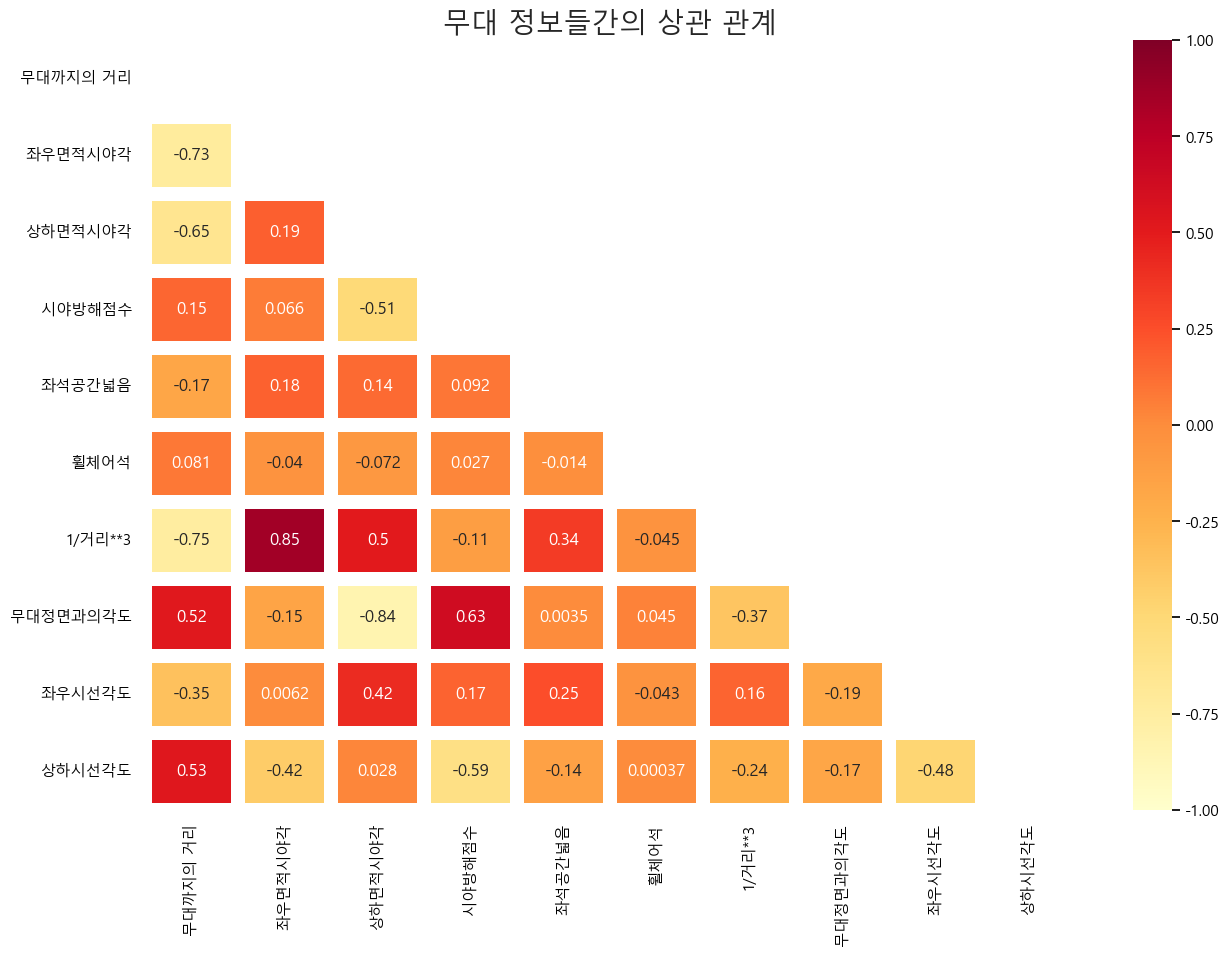

In [26]:
fig,ax = plt.subplots(figsize = (15,10))

corr = seat_table[seat_cols].corr()

mask = np.triu(np.ones_like(corr))

sns.heatmap(corr, mask = mask , annot = True, linewidths = 10, cmap = 'YlOrRd', vmin = -1 , vmax = 1, ax = ax)

ax.set_title('무대 정보들간의 상관 관계', fontsize = 20)

독립 변수들 간 상관 관계가 보이면서, 변수들이 서로 독립적이지 않음을 확인했다.

이에 변수의 개수를 줄이기 위해 차원 축소를 시행하도록 하였다.

In [27]:
pca = PCA(n_components = 2)
pca.fit(seat_information[seat_cols])
print('두 개의 주성분이 설명하는 분산량 : ', pca.explained_variance_ratio_ )
components = pca.fit_transform(seat_information[seat_cols])

두 개의 주성분이 설명하는 분산량 :  [9.99288376e-01 3.37813216e-04]


모든 변수를 사용할 필요 없이 차원 축소를 통해 제 1성분만 사용하여도 0.99 의 설명력을 갖는 주 성분으로 사용 할 수 있음을 확인하였다.

두 개의 주성분만을 이용하여 예술의 전당의 좌석 정보를 확인해보자

In [28]:
encoder = LabelEncoder()

decomponents_table = pd.DataFrame(
    {'제 1성분' : components[:,0],
    '제 2성분' : components[:,1],
    '층_라벨링' : encoder.fit_transform(seat_information['층']),
    '층' : seat_information['층']}
)

decomponents_table

,제 1성분,제 2성분,층_라벨링,층
0,-738.824095,-42.848526,0,1층
1,-776.119296,-41.462937,0,1층
2,-812.872659,-39.911957,0,1층
3,-850.358808,-38.211951,0,1층
4,-886.753984,-36.392741,0,1층
...,...,...,...,...
2500,-724.395903,-23.640581,1,2층
2501,-631.333532,-21.473808,1,2층
2502,-653.932071,-19.334229,1,2층
2503,-555.988717,-18.433483,1,2층


Text(0.5, 1.0, '무대까지의 거리 좌우면적시야각 상하면적시야각 시야방해점수 좌석공간넓음 휠체어석 1/거리**3 무대정면과의각도 좌우시선각도 상하시선각도\n 차원 축소한 모습 \n 설명되는 분산량 : 0.9996')

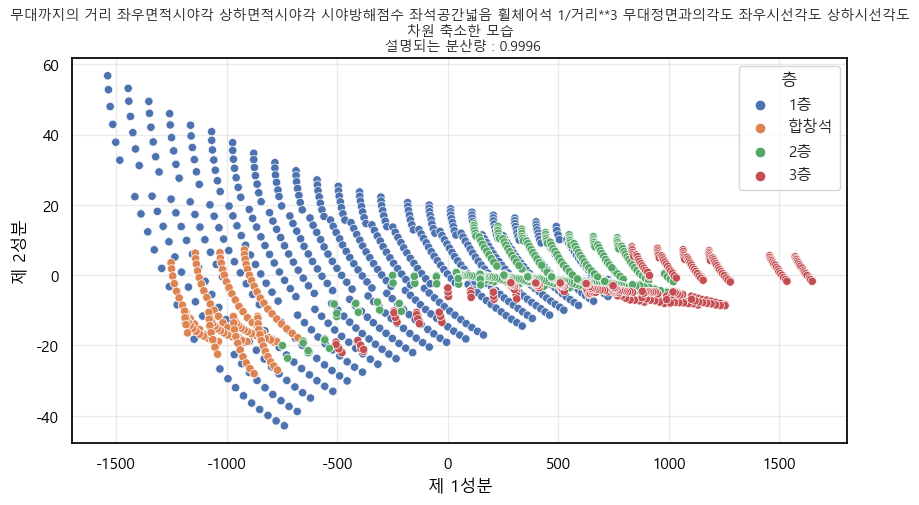

In [29]:
fig,ax = plt.subplots(figsize = (10,5))

variance_ratio = round(np.sum(pca.explained_variance_ratio_),4)

sns.scatterplot(
    data = decomponents_table,
    x = '제 1성분',
    y = '제 2성분',
    hue = '층',
    ax = ax
)

ax.set_title(' '.join(seat_cols) + f'\n 차원 축소한 모습 \n 설명되는 분산량 : {variance_ratio}', fontsize = 10)

In [30]:
seat_information['주성분'] = components[:,0] # 첫 번째 주성분을 담아주자 

file_path = "C:/Users/whileduck/Desktop/Github/Concert-Hall-Price-Model/data/"

seat_information.to_csv(file_path + 'seat_information_PCA.csv',index = False) # 추후 쓸 수 있도록 저장해주자

두 개의 주성분 만으로 좌석의 정보를 담는 것이 가능 할 것이라 생각된다 .

군집화를 할 때에는 차원축소를 시행한 후 군집 분석을 시행하도록 하자

종속적인 변수들을 추가해나가며 군집 분석시 노이즈가 끼는 것보다 차원을 축소하여 하나의 주성분을 이용해 그룹핑해보자

In [31]:
class ConditionSummaryTable:
    
    def __init__(self,seat_information):
        
        self.seat_information = seat_information
        self.seat_information = self.seat_information.rename(columns = {'전체_좌석' : 'seat'})
        
    def reservation_condition_table(self ,cond_df):
        
        
        self.reservation_grouping = cond_df.groupby('전체공연시간').agg({'좌석 오픈 여부' : np.sum, 
                                    '예매여부' : np.sum, 'price':np.mean,'거래까지걸린시간_시간' : [np.min,np.mean,np.max],
                                    '원가격추정' : [np.min, np.mean, np.max]}).reset_index()
        
        
        self.reservation_grouping['공연 예매율'] = self.reservation_grouping['예매여부'] / self.reservation_grouping['좌석 오픈 여부'] # 공연 별 예매율 계산 

        # self.reservation_grouping = self.reservation_grouping.rename(columns = {'원가격추정': '공연 별 평균 가격' })

        self.reservation_grouping.columns = [' '.join(col).strip() for col in self.reservation_grouping.columns.values]

        # 공연별 예매율 테이블 생성

        cols = ['play_date', 'play_st_time','pre_open_date','open_date', 'running_time', 
                'intermission','전체공연시간','콘서트홀클래식_누적검색량','예술의전당클래식_누적검색량', '서울클래식_누적검색량'] # 합병해주자 


        pre_table = pd.merge(self.reservation_grouping,cond_df[cols], on = '전체공연시간', how = 'left').drop_duplicates() # merge 후 중복을 제거 

        self.reservation_table = pre_table.reset_index(drop = True) # index 초기화 
        
        # 공연별 요약 테이블에서 EDA 할 때 용이하도록 날짜도 포함해서 만들도록 하자 

        self.reservation_table['연도'] = pd.to_datetime(self.reservation_table['전체공연시간']).map(lambda x: x.year)
        self.reservation_table['월'] = pd.to_datetime(self.reservation_table['전체공연시간']).map(lambda x: x.month)
        self.reservation_table['연 월'] = pd.to_datetime(self.reservation_table['연도'].astype(str) + '-' + reservation_table['월'].astype(str)) 
        self.reservation_table['일'] = pd.to_datetime(self.reservation_table['전체공연시간']).map(lambda x: x.day)
        self.reservation_table['시간'] = pd.to_datetime(self.reservation_table['전체공연시간']).map(lambda x: x.hour)
        self.reservation_table['요일'] =  pd.to_datetime(self.reservation_table['전체공연시간']).map(lambda x: x.weekday())  # 월요일 0 , 화요일 1 .... 일요일 6 으로 맵핑되도록 변경
        
        return self.reservation_table
    
    def seat_information_condition_table(self,cond_df):
        
        
        self.seat_grouping = cond_df.groupby('seat').agg({'예매여부': np.sum, '좌석 오픈 여부': np.sum, 
                                        '원가격추정':[np.min,np.mean, np.max], '거래까지걸린시간_시간':np.mean,
                                        '거래까지걸린시간_등수' : np.mean, '거래까지걸린시간_등수':[np.max, np.min],
                                        '표준화 등수 점수': np.mean}).reset_index()


        self.seat_grouping['좌석 예매율'] = self.seat_grouping['예매여부'] / self.seat_grouping['좌석 오픈 여부']
        self.seat_grouping = self.seat_grouping.rename(columns = {'price': '좌석 별 평균 가격'})


        self.seat_grouping.columns = [' '.join(col).strip() for col in self.seat_grouping.columns.values]
        
        self.pre_table = self.seat_grouping.reset_index(drop = True)
        

        self.seat_table = pd.merge(self.pre_table, self.seat_information, how = 'left', on = 'seat')
        
        return self.seat_table

In [32]:
def quantile_conditioning(data,  col):
    '''
    특정 컬럼의 quantile 값으로 컨디셔닝 하여 
    reservation table 을 return 하는 함수 
    '''
    qunt_25 = data[col].quantile(0.25)
    qunt_5 = data[col].quantile(0.5)
    qunt_75 = data[col].quantile(0.75)
    
    under_25 = data.loc[data[col] <= qunt_25, '전체공연시간'].astype(str).unique()
    between_25_50= data.loc[(data[col] >= qunt_25) & (data[col] < qunt_5), '전체공연시간'].astype(str).unique()
    between_50_75 = data.loc[(data[col] >= qunt_5) & (data[col] < qunt_75), '전체공연시간'].astype(str).unique()
    over_75 = data.loc[data[col] >= qunt_75, '전체공연시간'].astype(str).unique()
    
    cross_table = pd.DataFrame(
        [str(qunt_25),f'{qunt_25} ~ {qunt_5}', f'{qunt_5} ~ {qunt_75}',f'{qunt_75} 이상'],
        index = ['하위 25%', '하위 25% ~ 하위 50%', '하위 50% ~ 하위 75%', '상위 25%'],
    )
    
    display(cross_table.T)
    
    return under_25, between_25_50, between_50_75, over_75

# **이전 프로토타입에서 발생했던 문제를 찾았다**

이전 프로토타입에서는 가중치를 아무리 크게 주어도 군집화 시 가중치가 역할을 하지 못했다.

```

scaled_data = scaler.fit_transform(seat_table[cols] * weights) # 각 column 별 가중치를 곱해줘버려     

```

이 전 파일에서는 해당과 같이 weight 를 먼저 곱해준 후 스케일러를 사용했는데 이렇게 되면 가중치를 줘도 값들이 모두 0과 1 사이의 값으로 스케일링 되기 때문에 생기는 문제엿다. 



```

    if weights is not None: # 만약 가중치를 줄 것이라면
        scaled_data = scaler.fit_transform(seat_table[cols]) 
        scaled_data *= weights

```

로 변경해보자

In [33]:
def grouping(seat_table,n_clusters,cols, cmap = 'Set3', weights = None):
    
    scaler = MinMaxScaler()

    

    if weights is not None: # 만약 가중치를 줄 것이라면
        scaled_data = scaler.fit_transform(seat_table[cols]) # 각 column 별 가중치를 곱해줘버려     
        scaled_data *= weights
    else:
        scaled_data = scaler.fit_transform(seat_table[cols])


    fig,ax = plt.subplots(figsize = (30,10), subplot_kw = {'projection': '3d'}, ncols = 3, nrows = (len(cols) % 3) + 1)
    ax = ax.flatten()
    fig.subplots_adjust(hspace = 0.8)

    for i in range(len(cols)):
            

        model = KMeans(n_clusters = n_clusters)

        model.fit(scaled_data[:,:i+1])
        silhouette_avg = round(silhouette_score(scaled_data[:, :i + 1], model.labels_),2)



        ax[i].set_box_aspect([3,3,1])

        ax[i].scatter(
            data = seat_table,
            xs = 'X',
            ys = 'Y',
            zs = 'Z',
            c = model.labels_,
            cmap = cmap
        )

        ax[i].set_xlabel('X')
        ax[i].set_ylabel('Y')
        ax[i].set_zlabel('Z')
        

        title = '\n'.join(cols[:i+1])
        
        ax[i].set_title(title + f" \n 실루엣 계수 : {silhouette_avg}")

In [34]:
cst = ConditionSummaryTable(seat_information = seat_information)

In [35]:
copy_df = df.copy()
copy_df['전체공연시간'] = copy_df['전체공연시간'].astype(str) 

under_25, between_25_50, between_50_75, over_75 = quantile_conditioning(reservation_table, '원가격추정 amax')

under_25_summary = cst.seat_information_condition_table(copy_df[copy_df['전체공연시간'].str.contains('|'.join(under_25))])
between_25_50_summary = cst.seat_information_condition_table(copy_df[copy_df['전체공연시간'].str.contains('|'.join(between_25_50))])
between_50_75_summary = cst.seat_information_condition_table(copy_df[copy_df['전체공연시간'].str.contains('|'.join(between_50_75))])
over_75_summary = cst.seat_information_condition_table(copy_df[copy_df['전체공연시간'].str.contains('|'.join(over_75))])

,하위 25%,하위 25% ~ 하위 50%,하위 50% ~ 하위 75%,상위 25%
0,85000.0,85000.0 ~ 110000.0,110000.0 ~ 130000.0,130000.0 이상


데이터를 준비해주고 군집화를 시행해주자

가중치를 주지 않았을 때 

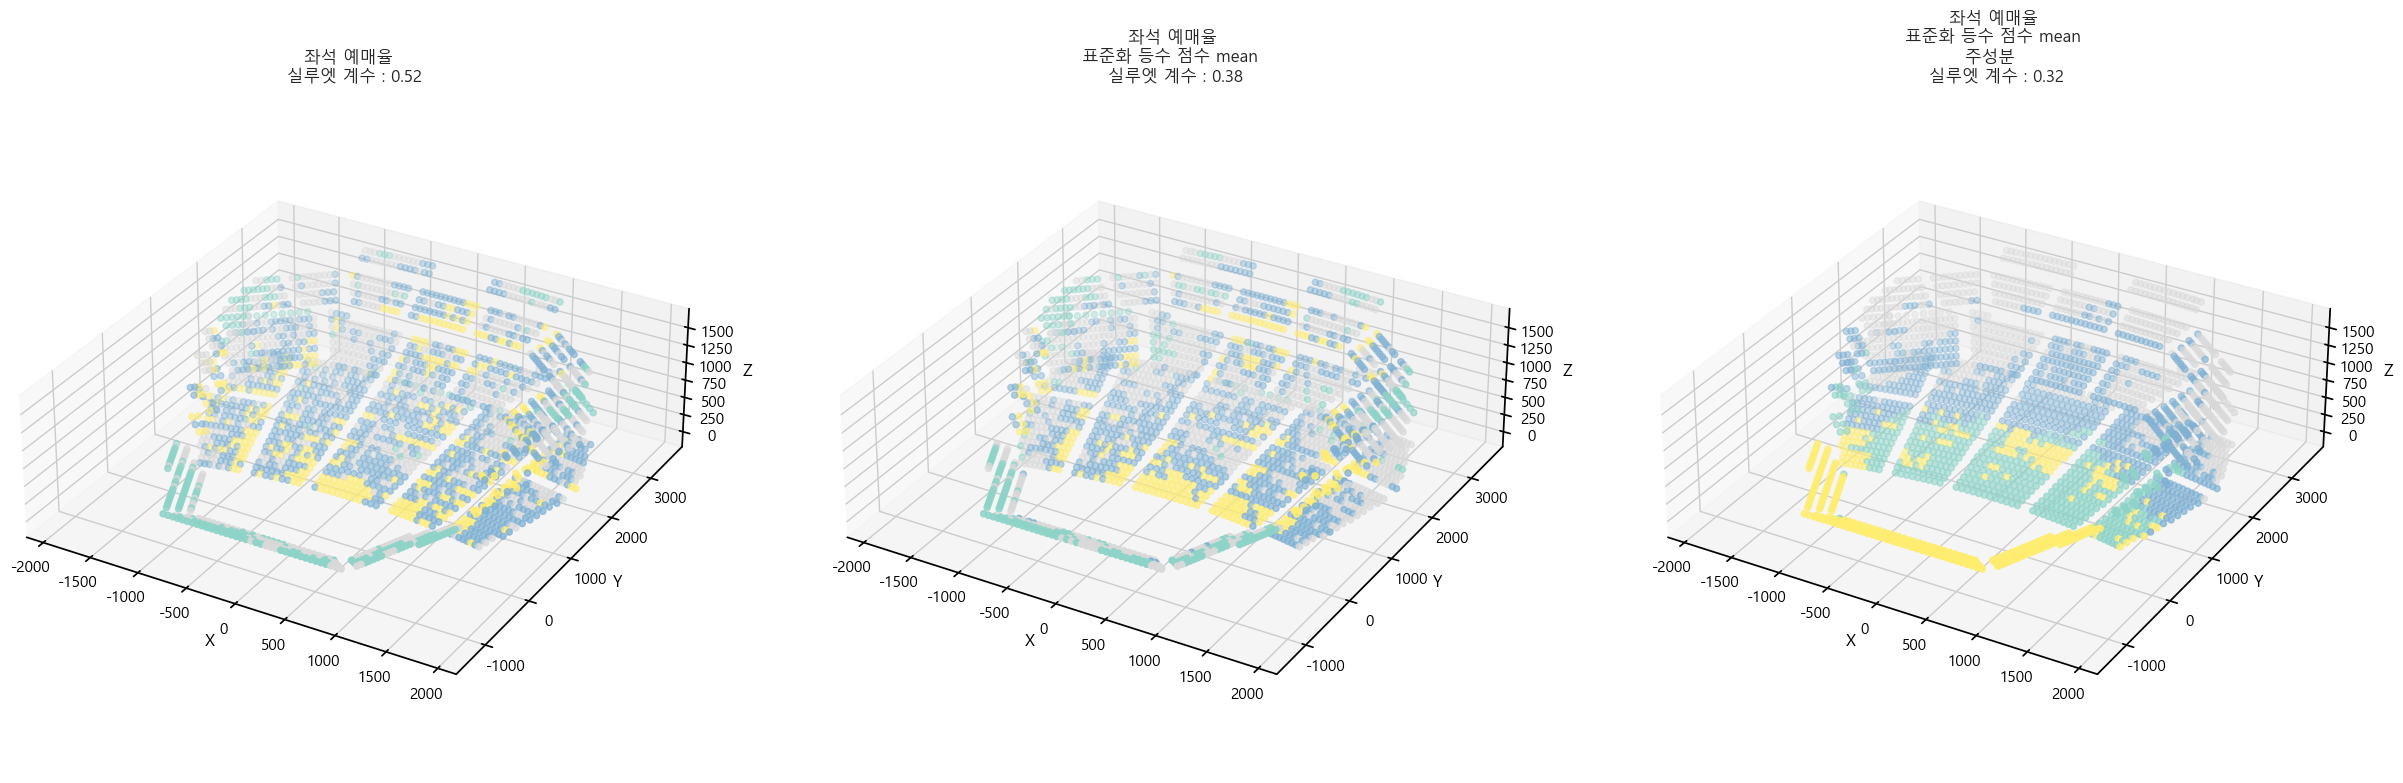

In [36]:
cols = ['좌석 예매율','표준화 등수 점수 mean','주성분'] 

grouping(over_75_summary,n_clusters = 4, cols = cols )

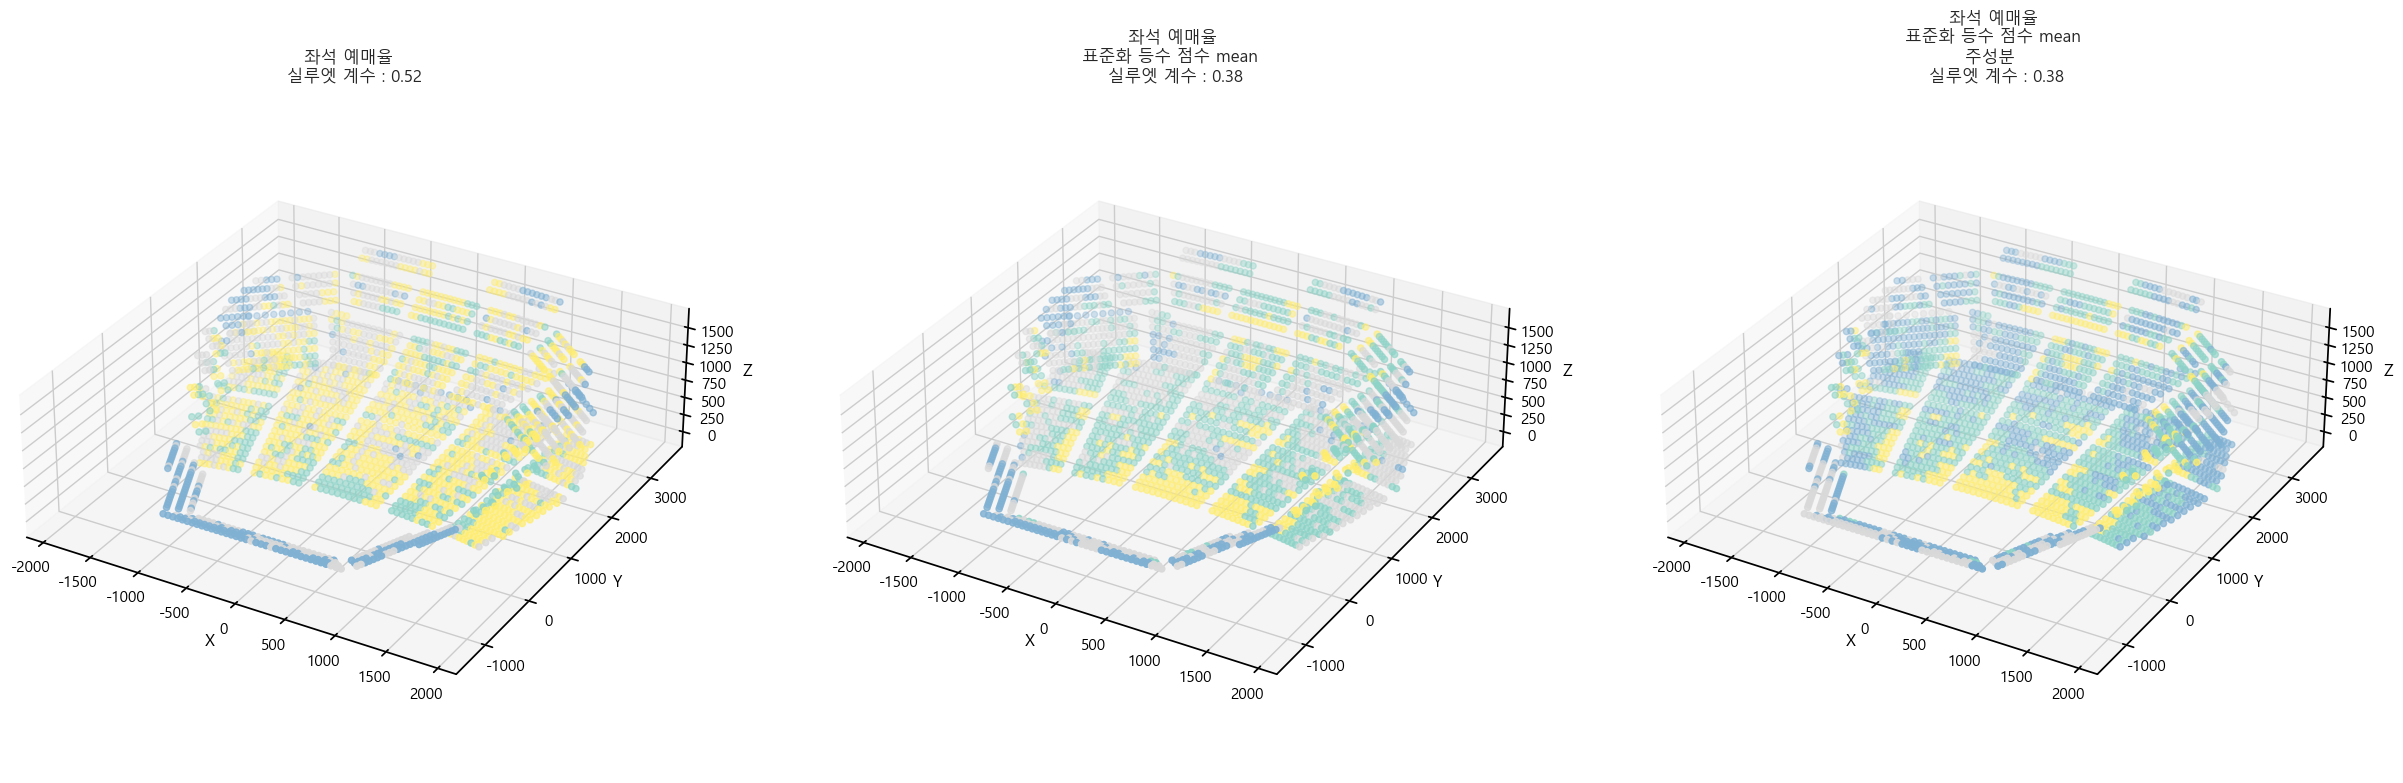

In [37]:
cols = ['좌석 예매율','표준화 등수 점수 mean','주성분'] 

grouping(over_75_summary,n_clusters = 4, cols = cols ,weights = np.array([100,100,1]))

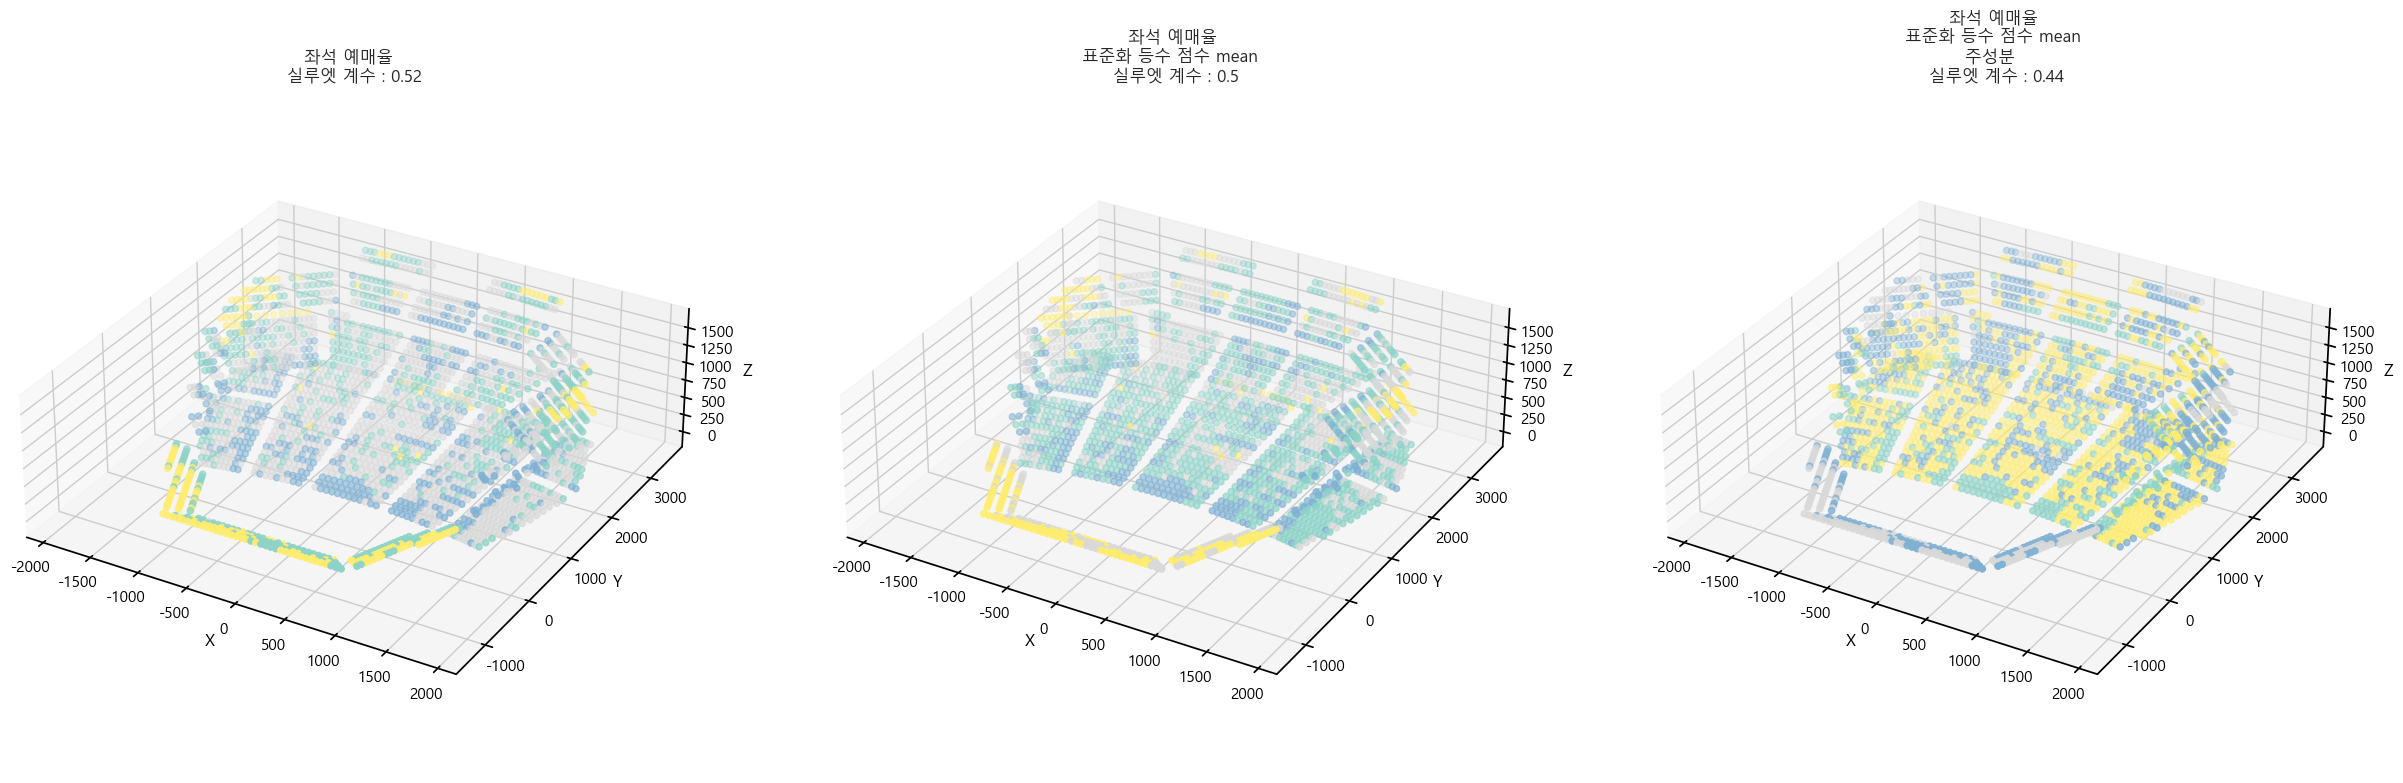

In [38]:
cols = ['좌석 예매율','표준화 등수 점수 mean','주성분'] 

grouping(over_75_summary ,n_clusters = 4, cols = cols , weights = np.array([10,1,1]))

### **차원 축소를 시행하고 군집화 하니 차원 축소를 하기 전보다 실루엣 계수가 많이 좋아진 모습을 볼 수 있다 !**

또한 동일한 데이터임에도 불구하고 가중치에 따라 군집분석 양상이 달라지는 것을 확인 할 수 있다